In [25]:
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
# FFNN
# 이미지의 숫자 예측
# 0~9까지의 숫자를 이미지화 인식 => 자동차 번호판

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
# target : 1000000000
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
import tensorflow as tf

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [104]:
# 128장의 이미지를 random하게 가져온다.
batch_x, batch_y = mnist.train.next_batch(128) # batch_x : image, batch_y : target
print(batch_x.shape) # 128장 * 784(=가로 28 * 세로 28의 이미지가 flatten되어 784)
learning_rate = 0.1  # hyper parameter
num_steps = 500      # epoch세대 
batch_size = 128     # mini batch 크기(속도를 고속으로, local해를 복구하기 위하여 mini batch사용)
display_step = 100   # 시각화하기 위함

# hidden layer가 2개
# 784(pixel 1개가 변수)
#  => 1번 레이어 = 784 * 256 -> 2번 레이어 256 * 256 -> 3번 레이어 256 * 10
n_hidden_1 = 256; n_hidden_2 = 256
num_input = 784; num_classes = 10 # target이 0~9(=10개)
X = tf.placeholder("float", [None, num_input]) # 128 x 784
Y = tf.placeholder("float", [None, num_classes]) # 128 x 10
# 가중치(설명력, 계수)
weights = {
    "h1" : tf.Variable(tf.random_normal([num_input, n_hidden_1])),   # 784 x 256
    "h2" : tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),  # 256 x 256
    "out" : tf.Variable(tf.random_normal([n_hidden_2, num_classes])) # 256 x 10
}
# bias(activation) - 가중치 한 덩어리당 bias가 반드시 존재한다.
# bias는 변수개수만큼 존재한다.
biases = {
    "b1" : tf.Variable(tf.random_normal([n_hidden_1])),
    "b2" : tf.Variable(tf.random_normal([n_hidden_2])),
    "out" : tf.Variable(tf.random_normal([num_classes]))
}

(128, 784)
Tensor("Placeholder:0", shape=(?, 784), dtype=float32)


In [22]:
def neural_net(x): # X = 128 x 784
    # 128 x 784, 784 x 256 => 128 x 256 전달 데이터(tensor)(*bias는 더해주기만 하는거라서 개수로 안함)
    layer_1 = tf.add(tf.matmul(x, weights["h1"]), biases["b1"])
    # 128 x 256, 256 x 256 => 128 x 256
    layer_2 = tf.add(tf.matmul(layer_1, weights["h2"]), biases["b2"])
    # 128 x 256, 256 x 10 => 128 x 10
    out_layer = tf.matmul(layer_2, weights["out"]) + biases["out"]
    
    return out_layer

In [23]:
logits = neural_net(X) # =128 x 10
# 경사하강법 사용을 위해서는 미분이 가능해야한다 -> 분류하여 미분값을 취한다
loss_op = tf.reduce_mean(
    # softmax : 확률값으로 계산
    tf.nn.softmax_cross_entropy_with_logits_v2( # one-hot encoding 된 값 * log(확률값)
        logits = logits, labels = Y))
# 최적화기 : 기울기, 학습율(Adam = momentum + propgrad)
# Adagrad : learning rate를 처음에는 크게 -> 점점 작게
# propgrad : Adagrad + adaptive하게(현재 상태를 봐가면서 적응적으로)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# argmax : 가장 큰 값의 index(one-hot encoding되어있음) => 그 자체가 target이다.
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1)) # 1, 0
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

In [24]:
with tf.Session() as sess: # session연결 = GPU에 연결(CPU와 GPU 연결을 일반화하기 위해 session이 있음)
    sess.run(init)
    for step in range(1, num_steps + 1): # epoch
        # batch_x : 128 x 784, batch_y : 128 x 10
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy],
                                feed_dict = {X: batch_x, Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(loss) +
                 ", Training Accuracy= " + "{:.3f}".format(acc))
            print("테스트 정확도 : ",
                  sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

Step 1, Minibatch Loss= 12806.0762, Training Accuracy= 0.367
테스트 정확도 :  0.2387
Step 100, Minibatch Loss= 423.4575, Training Accuracy= 0.828
테스트 정확도 :  0.8359
Step 200, Minibatch Loss= 153.4784, Training Accuracy= 0.852
테스트 정확도 :  0.8418
Step 300, Minibatch Loss= 96.5707, Training Accuracy= 0.852
테스트 정확도 :  0.8383
Step 400, Minibatch Loss= 40.6246, Training Accuracy= 0.891
테스트 정확도 :  0.858
Step 500, Minibatch Loss= 62.8232, Training Accuracy= 0.883
테스트 정확도 :  0.8571


In [46]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import tensorflow as tf
boston = load_boston()
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df["const"] = np.ones(df.shape[0])
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,const
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,1.0
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,1.0
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,1.0
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,1.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,1.0


In [47]:
n, m = df.shape
X = tf.placeholder(tf.float64, shape=(n, m))
y = tf.placeholder(tf.float64, shape=(n, 1))
XT = tf.transpose(X) # 14 x 506

In [49]:
# 행렬식
# 거듭제곱 : 상관계수 ( 506(Data point) x 14(변수) )
# 14 x 506, 506 x 14 => 14 x 14 (상관행렬)
# -> 역행렬 14 x 14, 14 x 506 => 14 x 506
# 14 x 506, 506 x 1 => 14 x 1(가중치)
# 역행렬을 이용해서 가중치를 결정
w = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y) # 14 x 1
y_pred = tf.matmul(X, w) # 506 x 14, 14 x 1 => 506 x 1 회귀식

with tf.Session() as sess:
    y_pred = sess.run(y_pred, feed_dict={X: df.values,
                                         y: boston.target.reshape(-1, 1)})
print("예측한 집값 :", y_pred[19], "실제 집값 :", boston.target[19])

예측한 집값 : [18.40613603] 실제 집값 : 18.2


In [51]:
import tensorflow as tf
sess = tf.Session()

val = [0,2,3]
val = tf.tile(val, [5])
print("홑일 때 ", sess.run(val))

홑일 때  [0 2 3 0 2 3 0 2 3 0 2 3 0 2 3]


In [54]:
# tile은 차원을 확대하지는 않는다.
val = [[1,1,1],[2,2,2],[3,3,3]] # 3 x 3
val = tf.tile(val, [5,2]) # 15 x 6
print("2차원일때\n", sess.run(val))

2차원일때
 [[1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]]


In [56]:
input_vecs = [[1., 2.], [2., 1.], [-2., -1.]]
tiled_vecs = tf.tile(input_vecs, [1, 3])
print(sess.run(tiled_vecs))
tiled_vecs = tf.tile(input_vecs, [2, 3])
print(sess.run(tiled_vecs))

[[ 1.  2.  1.  2.  1.  2.]
 [ 2.  1.  2.  1.  2.  1.]
 [-2. -1. -2. -1. -2. -1.]]
[[ 1.  2.  1.  2.  1.  2.]
 [ 2.  1.  2.  1.  2.  1.]
 [-2. -1. -2. -1. -2. -1.]
 [ 1.  2.  1.  2.  1.  2.]
 [ 2.  1.  2.  1.  2.  1.]
 [-2. -1. -2. -1. -2. -1.]]


In [57]:
# kmeans : k가 결정 => 중심이 발생
#  - 각 데이터의 중심값을 빼서 거리값을 계산

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from sklearn.preprocessing import scale
from tensorflow.python.framework import ops

ops.reset_default_graph() # 그라프 초기화
sess = tf.Session()
iris = datasets.load_iris() # 4개의 변수 - target

In [100]:
num_pts = len(iris.data) # 행의 수
num_feats = len(iris.data[0]) # 열의 수
k = 3 # 군집수
generations = 25 # epoch
data_points = tf.Variable(iris.data)
# 레이블 변수
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype = tf.int64))
# 중심데이터를 랜덤으로 취한다.
# 중심의 열변수개수 = 4개
rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)])
centroids = tf.Variable(rand_starts) # 중심
centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), [num_pts, k, num_feats]) # (150,3,4)
point_matrix = tf.reshape(tf.tile(data_points, [1, k]), [num_pts, k, num_feats]) # (150,3,4)
distances = tf.reduce_sum(tf.square(point_matrix - centroid_matrix), axis=2)  # (150,3,1)
centroid_group = tf.argmin(distances, 1) # argmin : 값을 기준으로 index를 추출(2개 전제 - 인덱스, 실제값 비교)

In [101]:
# 그룹별로 거리의 평균
# 중심거리를 재계산해서 중심값을 재할당
def data_group_avg(group_ids, data):
    # 라벨번호로 값의 합계 : 라벨 - 값, 그룹이 3개
    sum_total = tf.unsorted_segment_sum(data, group_ids, 3)
    # 그룹의 전체 개수
    num_total = tf.unsorted_segment_sum(tf.ones_like(data), group_ids, 3) # _like : 사이즈 일치
    avg_by_group = sum_total / num_total # 그룹의 평균거리
    return (avg_by_group)
means = data_group_avg(centroid_group, data_points)
# update : node를 결정
update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))
init = tf.global_variables_initializer()
sess.run(init)

In [102]:
for i in range(generations):
    print("Calculating gen {}, out of {}.".format(i, generations)) # _ : 실행의 마지막 결과값
    # centroid_group : 그룹번호 결정
    # update : 군집의 중심값을 재계산하고 그룹을 변경
    _, centroid_group_count = sess.run([update, centroid_group])
    group_count = []
    for ix in range(k): # 군집별 카운트
        group_count.append(np.sum(centroid_group_count == ix))
    print("Group counts: {}".format(group_count))
    
# 결정된 중심값, 할당된 군집번호
[centers, assignments] = sess.run([centroids, cluster_labels])

Calculating gen 0, out of 25.
Group counts: [57, 12, 81]
Calculating gen 1, out of 25.
Group counts: [53, 22, 75]
Calculating gen 2, out of 25.
Group counts: [51, 32, 67]
Calculating gen 3, out of 25.
Group counts: [50, 35, 65]
Calculating gen 4, out of 25.
Group counts: [50, 38, 62]
Calculating gen 5, out of 25.
Group counts: [50, 38, 62]
Calculating gen 6, out of 25.
Group counts: [50, 38, 62]
Calculating gen 7, out of 25.
Group counts: [50, 38, 62]
Calculating gen 8, out of 25.
Group counts: [50, 38, 62]
Calculating gen 9, out of 25.
Group counts: [50, 38, 62]
Calculating gen 10, out of 25.
Group counts: [50, 38, 62]
Calculating gen 11, out of 25.
Group counts: [50, 38, 62]
Calculating gen 12, out of 25.
Group counts: [50, 38, 62]
Calculating gen 13, out of 25.
Group counts: [50, 38, 62]
Calculating gen 14, out of 25.
Group counts: [50, 38, 62]
Calculating gen 15, out of 25.
Group counts: [50, 38, 62]
Calculating gen 16, out of 25.
Group counts: [50, 38, 62]
Calculating gen 17, out 

In [103]:
# set : key의 중복을 불허한다.
def most_common(my_list):
    return (max(set(my_list), key=my_list.count))
# 라벨링
label0 = most_common(list(assignments[0:50]))
label1 = most_common(list(assignments[50:100]))
label2 = most_common(list(assignments[100:150]))

group0_count = np.sum(assignments[0:50] == label0)
group1_count = np.sum(assignments[50:100] == label1)
group2_count = np.sum(assignments[100:150] == label2)

accuracy = (group0_count + group1_count + group2_count) / 150.
print("Accuracy : {:.2}".format(accuracy))

Accuracy : 0.89


In [112]:
# 틱택토 게임 시작
import tensorflow as tf
import csv
import random
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [113]:
response = 6
batch_size = 50
symmetry = ["rotate180", "rotate90", "rotate270", "flip_v", "flip_h"]

In [114]:
# 말판
def print_board(board):
    symbols = ["O", " ", "X"]
    board_plus1 = [int(x) + 1 for x in board]
    print(" " + symbols[board_plus1[0]] + " | " + symbols[board_plus1[1]]
         + " | " + symbols[board_plus1[2]])
    print("__________")
    print(" " + symbols[board_plus1[3]] + " | " + symbols[board_plus1[4]]
         + " | " + symbols[board_plus1[5]])
    print("__________")
    print(" " + symbols[board_plus1[6]] + " | " + symbols[board_plus1[7]]
         + " | " + symbols[board_plus1[8]])

In [115]:
# 다양한 경우를 충족하기 위해 변화
def get_symmetry(board, response, transformation):
    if transformation == "rotate180":
        new_response = 8 - response
        return (board[::-1], new_response)
    elif transformation == "rotate90":
        new_response = [6,3,0,7,4,1,8,5,2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return ([value for item in tuple_board for value in item], new_response)
    elif transformation == "rotate270":
        new_response = [2,5,8,1,4,7,0,3,6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return ([value for item in tuple_board for value in item], new_response)
    elif transformation == "flip_v": # vertical
        new_response = [6,7,8,3,4,5,0,1,2].index(response)
        return (board[6:9] + board[3:6] + board[0:3], new_response)
    elif transformation == "flip_h": # horizontal
        new_response = [2,1,0,5,4,3,8,7,6].index(response)
        new_board = board[::-1]
        return (new_board[6:9] + new_board[3:6] + new_board[0:3], new_response)
    else:
        raise ValueError("해당하는 경우가 없음")

In [116]:
# 파일로부터 말 규칙 로딩
def get_moves_from_csv(csv_file):
    moves = []
    with open(csv_file, "rt") as csvfile:
        reader = csv.reader(csvfile, delimiter = ",")
        for row in reader :
            moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return (moves)

In [117]:
def get_rand_move(moves, n=1, rand_transforms=2):
    (board, response) = random.choice(moves)
    possible_transforms = ["rotate90", "rotate180", "rotate270", "flip_v", "flip_h"]
    
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, response) = get_symmetry(board, response, random_transform)
        
    return (board, response)

In [118]:
moves = get_moves_from_csv("tictactoe_moves.csv")
train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move(moves))

In [119]:
def init_weights(shape):
    return(tf.Variable(tf.random_normal(shape)))

In [120]:
def model(X, A1, A2, bias1, bias2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
    layer2 = tf.add(tf.matmul(layer1, A2), bias2)
    return (layer2)

In [121]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
Y = tf.placeholder(dtype=tf.int32, shape=[None])
A1 = init_weights([9, 81])
bias1 = init_weights([81])
A2 = init_weights([81, 9])
bias2 = init_weights([9])
model_output = model(X, A1, A2, bias1, bias2)

# 분류 : 1~0사이의 확률값
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = model_output, labels = Y)) # 확률
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
prediction = tf.argmax(model_output, 1)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [122]:
loss_vec = []
for i in range(10000):
    # 50개를 임의적으로 선택
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace = False)
    batch_data = [train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    sess.run(train_step, feed_dict={X: x_input, Y: y_target})
    temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
    loss_vec.append(temp_loss)
    if i % 500 == 0 :
        print("Iteration " + str(i) + " Loss: " + str(temp_loss))

Iteration 0 Loss: 7.3570585
Iteration 500 Loss: 1.7680413
Iteration 1000 Loss: 1.5676608
Iteration 1500 Loss: 1.3956932
Iteration 2000 Loss: 1.3381006
Iteration 2500 Loss: 1.2517333
Iteration 3000 Loss: 1.2859079
Iteration 3500 Loss: 1.0231106
Iteration 4000 Loss: 1.056713
Iteration 4500 Loss: 0.991197
Iteration 5000 Loss: 1.0500451
Iteration 5500 Loss: 1.0318258
Iteration 6000 Loss: 0.93362963
Iteration 6500 Loss: 0.75592536
Iteration 7000 Loss: 0.82352346
Iteration 7500 Loss: 0.7267734
Iteration 8000 Loss: 0.74781775
Iteration 8500 Loss: 0.71243757
Iteration 9000 Loss: 0.7828669
Iteration 9500 Loss: 0.76656175


In [123]:
test_board = [-1,0,0,1,-1,-1,0,0,1]
train_set = [x for x in train_set if x[0] != test_board]

In [124]:
# 게임의 승패 결정
def check(board):
    wins = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8], [0,4,8], [2,4,6]]
    for i in range(len(wins)):
        if board[wins[i][0]] == board[wins[i][1]] == board[wins[i][2]] == 1.:
            return (1)
        elif board[wins[i][0]] == board[wins[i][1]] == board[wins[i][2]] == -1.:
            return (-1)
    return (0)

In [127]:
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0
while not win_logical:
    player_index = input("이동하고 싶은 인덱스를 입력하세요 (0-8):")
    num_moves += 1
    game_tracker[int(player_index)] = 1.
    [potential_moves] = sess.run(model_output, feed_dict={X: [game_tracker]})
    # 말여부를 확인해서 가능한 값을 선택
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x == 0.0]
    # 허락위치에 있는 것인지 확인
    model_move = np.argmax([x if ix in allowed_moves else -999.0
                           for ix, x in enumerate(potential_moves)])
    game_tracker[int(model_move)] = -1.
    print("모델이 이동하였습니다.")
    print_board(game_tracker)
    if check(game_tracker) == 1 or num_moves >= 20:
        print("게임 종료! 승리하였습니다!")
        win_logical = True
    elif check(game_tracker) == -1:
        print("게임 종료! 졌습니다!")
        win_logical = True
# 틱택토 게임 끝

이동하고 싶은 인덱스를 입력하세요 (0-8):0
모델이 이동하였습니다.
 X |   |  
__________
   | O |  
__________
   |   |  
이동하고 싶은 인덱스를 입력하세요 (0-8):0
모델이 이동하였습니다.
 X |   |  
__________
   | O |  
__________
 O |   |  
이동하고 싶은 인덱스를 입력하세요 (0-8):0
모델이 이동하였습니다.
 X |   | O
__________
   | O |  
__________
 O |   |  
게임 종료! 졌습니다!


In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

def save_fig(fig_id, tight_layout=True):
    path = os.path.join("./images/", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

In [84]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [85]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
# 70(높이:행), 120(가로:열)
image = china[150:220, 130:250] # clipping
height, width, channels = image.shape # channels : R,G,B 3개
image_grayscale = image.mean(axis=2).astype(np.float32) # channels별(axis=2)로 묶어서 평균 계산
images = image_grayscale.reshape(1, height, width, 1)

In [86]:
# 흑백
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest") # interpolation : 보간법
    plt.axis("off") # 이미지 축 생략
# 컬러
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation="nearest")
    plt.axis("off")

In [110]:
# filter 생성
import numpy as np
# shape=(filter의 높이, 가로, 입력채널, 출력채널)
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32) # filter가 2개 필요하다.
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1 # 하얀게 가로로
fmap[:, :, 0, 1]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

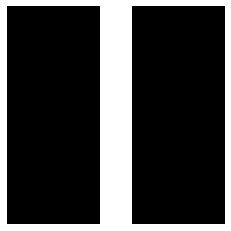

******************************************
******************************************
******************************************


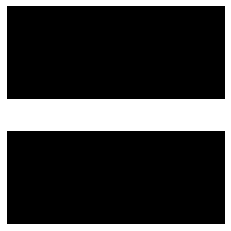

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [88]:
plot_image(fmap[:, :, 0, 0])
plt.show()
print("******************************************")
print("******************************************")
print("******************************************")
plot_image(fmap[:, :, 0, 1])
plt.show()
print(fmap[:, :, 0, 0])


In [104]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
# convolution은 1d(text), 2d(image), 3d(동영상)
# convolution, filter, padding, strides
# 70 x 120 => 70 x 120 <- padding="SAME"이므로 출력이미지도 똑같은 크기
# * padding이 "SAME"이 아닌 경우 출력이미지 크기 : 64 x (120-7+1)
# padding 옵션 : SAME, VALID
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=False)

In [105]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

Saving figure china_original


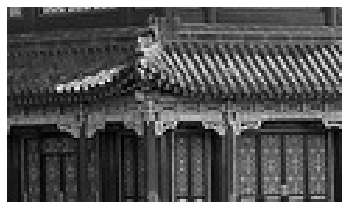

In [106]:
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical


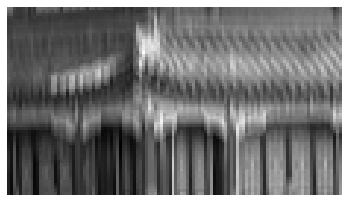

In [107]:
plot_image(output[0, :, :, 0]) # 0번 필터 적용 : 세로줄
save_fig("china_vertical", tight_layout=False)
plt.show()

Saving figure china_horizontal


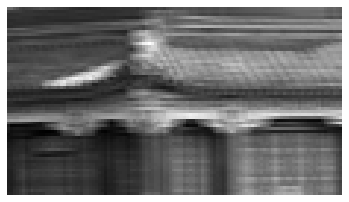

In [108]:
plot_image(output[0, :, :, 1]) # 1번 필터 적용 : 가로줄
save_fig("china_horizontal", tight_layout=False)
plt.show()